In [ ]:
# Load the csv file directly in here
# Write a separate function for filtering out the sentences

In [ ]:
import json
import numpy as np
import pandas as pd

from transformers import BertTokenizerFast, BertModel
import torch
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import SpectralCoclustering

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/sentence_data_bert_dpgmm100k_wordsetlarge_mixedSentFalse_pca2d_priorNone.csv"

In [ ]:
pre_df = pd.read_csv(path)

In [ ]:
print(pre_df.columns)

Index(['Unnamed: 0', 'target', 'converged', 'sentences', 'target_index',
       'speaker', 'age', 'name', 'filename', 'target_pos',
       'concreteness_context', 'concreteness_full', 'sense_label',
       'distance_to_sense_mean', 'X', 'Y'],
      dtype='object')


In [ ]:
df = pre_df[["target", "sentences", "sense_label", "distance_to_sense_mean"]]

In [ ]:
print(df.head())

  target                                          sentences  sense_label  \
0    you  huh ? oh look at that . there's a picnic table...          8.0   
1    you       can you take him out ? boom_boom_boom_boom .         17.0   
2    you                          . oh . did you say baby ?         17.0   
3    you  where's another person ? can you get another o...         17.0   
4    you  wanna put somebody to bed ? can you put a pers...         48.0   

   distance_to_sense_mean  
0                0.124442  
1                0.093910  
2                0.087689  
3                0.093342  
4                0.160052  


In [ ]:
print(df.shape)

(4959215, 4)


In [ ]:
df_bat = df[df["target"] == "bat"].copy()

In [ ]:
print(df_bat.head())

        target                                          sentences  \
4844451    bat                           play with that red bat .   
4844452    bat  oh the red bat . oh we're going to go back in ...   
4844453    bat  stand on the step zoom . here we go over the b...   
4844454    bat  it's gonna get on the truck goes away . that ?...   
4844455    bat      want ta do it with the bat . you see my bat .   

         sense_label  distance_to_sense_mean  
4844451          5.0                0.163128  
4844452          5.0                0.202803  
4844453          0.0                0.152340  
4844454          0.0                0.135013  
4844455          0.0                0.079334  


In [ ]:
print(df_bat.shape)

(344, 4)


In [ ]:
# "closest-50-sentences" approach
df_sorted = df_bat.sort_values(by="distance_to_sense_mean", ascending=True)
df_top50 = df_sorted.head(50)

In [ ]:
print(df_top50.shape)

(50, 4)


In [ ]:
print(df_top50.head())

        target                                          sentences  \
4844504    bat         a bat . one bat , two bats . what's that ?   
4844515    bat                        a bat . it's called a bat .   
4844544    bat  a baseball player and there's a bat . and that...   
4844609    bat                 it's a bat . it's it's a bat man .   
4844462    bat  star . and I'm gonna play with the bat . no I'...   

         sense_label  distance_to_sense_mean  
4844504          6.0                0.038881  
4844515          6.0                0.043297  
4844544          6.0                0.047286  
4844609          6.0                0.048559  
4844462          0.0                0.049746  


In [ ]:
unique_labels = df_top50["sense_label"].unique()
print(unique_labels)

[6. 0.]


In [ ]:
bat_clusters = {str(label): [] for label in unique_labels}

In [ ]:
for label in unique_labels:
  sentence_list = df_top50.loc[df_top50["sense_label"] == label, "sentences"].to_list()
  bat_clusters[str(label)] = sentence_list

In [ ]:
print(bat_clusters['0.0'][:5])

["star . and I'm gonna play with the bat . no I'm gonna go put it over the tennis court okay find my bat .", 'what do you do with the bat ?', "hey after we're through making a ax we could play baseball . I could hold the ax . I could hold the bat like this bat . and you could hold a ball like this ball „ okay ?", 'I want play with the bat .', "this is definitely like the follow through . it's not like the beginning of the swing it's the follow through because the bat would be on the other side ."]


In [ ]:
# print example sentences
for label in bat_clusters.keys():
  print(f"Label: {label}")
  print(bat_clusters[label][:5])
  print()

Label: 6.0
["a bat . one bat , two bats . what's that ?", "a bat . it's called a bat .", "a baseball player and there's a bat . and that's a bat that you hit with and ...", "it's a bat . it's it's a bat man .", "also a bat . there's bats at Halloween but that's pa- that's pretend ."]

Label: 0.0
["star . and I'm gonna play with the bat . no I'm gonna go put it over the tennis court okay find my bat .", 'what do you do with the bat ?', "hey after we're through making a ax we could play baseball . I could hold the ax . I could hold the bat like this bat . and you could hold a ball like this ball „ okay ?", 'I want play with the bat .', "this is definitely like the follow through . it's not like the beginning of the swing it's the follow through because the bat would be on the other side ."]



In [ ]:
# Example sentences:
# "it's a bat . it's it's a bat man ."
# "also a bat . there's bats at Halloween but that's pa- that's pretend ."

# "...it's not like the beginning of the swing it's the follow through because the bat would be on the other side ."
# "...no I'm gonna go put it over the tennis court okay find my bat ."

In [ ]:
# Load the BERT model
# Load BERT model
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased", output_hidden_states=True)
model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
! pip install ipdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.6 MB/s eta 0:00:00


In [ ]:
# Fixing the create_vector function
# Generate the BERT vectors
def bert_vectors(input):
    input_tokens = tokenizer(
        input, is_split_into_words=True, return_tensors="pt", truncation=True,
        max_length=512
    )
    hidden_vectors = model(
        **input_tokens, output_hidden_states=True
    ).hidden_states
    return hidden_vectors

In [ ]:
# Modification of create_vectors()
def create_vectors_masked(sentence, target_word):
  # Masking is done for all sentence (cluster + glosses)

  # The processing for masking target words
  mask = "[MASK]"

  # In the original code, "target_word" was introduced in an earlier part of the child_clustering class,
  # here I assume it's basically indexing the position of the target word
  # target_index = sentence.index(target_word)

  # sentence_context = [word if word != target_word else mask for word in sentence] # This is splitting into characters one at a time

  sentence_split = sentence if isinstance(sentence, (list, tuple)) else str(sentence).split()
  for i in range(len(sentence_split)):
    if sentence_split[i] == target_word: # not assigning the element properly
      sentence_split[i] = mask

  #import ipdb; ipdb.set_trace() # check output

  # Averaging the last 6 layers of each vector & removing first and last token
  all_hidden_vectors = bert_vectors(sentence_split)
  last_n_layers_averaged = (torch.stack(all_hidden_vectors[-6:]).mean(dim=0).squeeze(0))
  last_n_layers_averaged = last_n_layers_averaged[1:-1]
  # assert len(tokenized_context) == len(last_n_layers_averaged)

  # context_vector branch - returning the vector instead of appending to the attribute in self
  context_averaged = last_n_layers_averaged.mean(dim=0).detach().numpy()
  return context_averaged

In [ ]:
def create_vectors_unmasked(sentence, target_word):
  tokens = sentence if isinstance(sentence, (list, tuple)) else str(sentence).split()

  # Check sentence output

  all_hidden_vectors = bert_vectors(tokens)
  last_n_layers_averaged = (torch.stack(all_hidden_vectors[-6:]).mean(dim=0).squeeze(0))
  last_n_layers_averaged = last_n_layers_averaged[1:-1]
  # assert len(tokenized_context) == len(last_n_layers_averaged)

  context_averaged = last_n_layers_averaged.mean(dim=0).detach().numpy()
  return context_averaged

In [ ]:
masked_cluster_average = []
unmasked_cluster_average = []

for label in bat_clusters.keys():
  cluster_list = bat_clusters[label]
  masked_list = []
  unmasked_list = []
  for sent in cluster_list:
    masked_output = create_vectors_masked(sent, "bat")
    masked_list.append(masked_output)
    unmasked_output = create_vectors_unmasked(sent, "bat")
    unmasked_list.append(unmasked_output)

  # take the average of all of the embeddings in that cluster
  masked_avg = np.vstack(masked_list).mean(axis=0)
  unmasked_avg = np.vstack(unmasked_list).mean(axis=0)

  # Append the average embeddings
  masked_cluster_average.append(masked_avg)
  unmasked_cluster_average.append(unmasked_avg)

In [ ]:
# The glosses come from elementary level of Wordsmyth kids
bat_glosses = {
    "def_1": "A bat is something we use to hit the ball in baseball or other sports. In baseball, the bat is made of wood or metal.",
    "def_2": "When you bat in the game of baseball, you have a chance to hit the ball.",
    "def_3": "	A bat is a small mammal that can fly. Bats have wings that are much longer than their bodies. They usually fly at night, and they eat many, many insects."
}

In [ ]:
masked_glosses_average = []
unmasked_glosses_average = []

# Loop through the dictionary
for label in bat_glosses.keys():
  gloss = bat_glosses[label]
  masked_output = create_vectors_masked(gloss, "bat")
  masked_glosses_average.append(masked_output)

  unmasked_output = create_vectors_unmasked(gloss, "bat")
  unmasked_glosses_average.append(unmasked_output)

In [ ]:
cosine_masked = cosine_similarity(masked_cluster_average, masked_glosses_average)
cosine_unmasked = cosine_similarity(unmasked_cluster_average, unmasked_glosses_average)

In [ ]:
cluster_names = ["cluster_1", "cluster_2"]
gloss_names = ["def_1", "def_2", "def_3"]

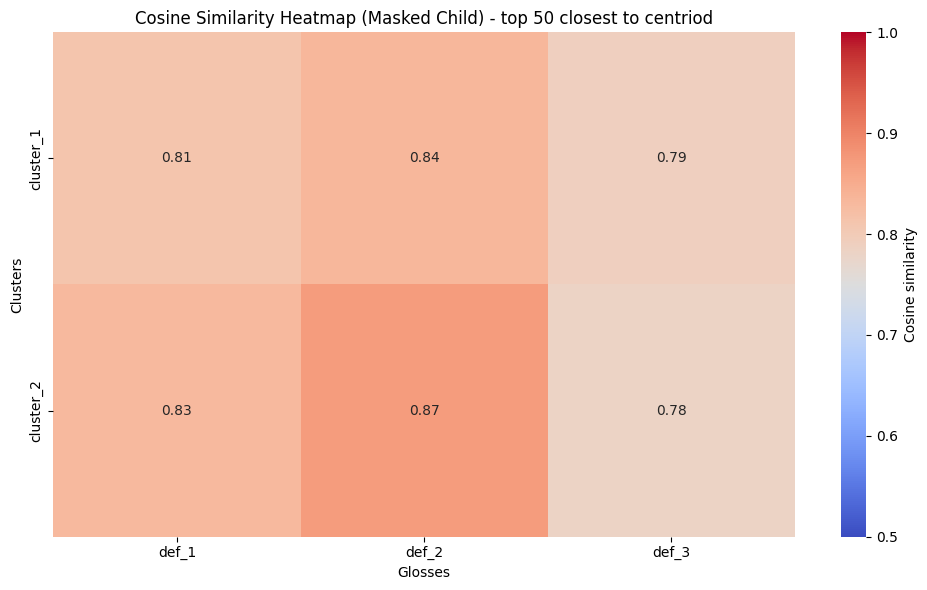

In [ ]:
# Heatmap for masked
plt.figure(figsize=(10,6))

sns.heatmap(
    cosine_masked,
    xticklabels=gloss_names,   # x = clusters
    yticklabels=cluster_names,     # y = glosses
    cmap="coolwarm",
    vmin=0.5, vmax=1,
    annot=True, fmt=".2f",
    cbar_kws={"label": "Cosine similarity"}
)

plt.xlabel("Glosses")
plt.ylabel("Clusters")
plt.title("Cosine Similarity Heatmap (Masked Child) - top 50 closest to centriod")
plt.tight_layout()
plt.show()

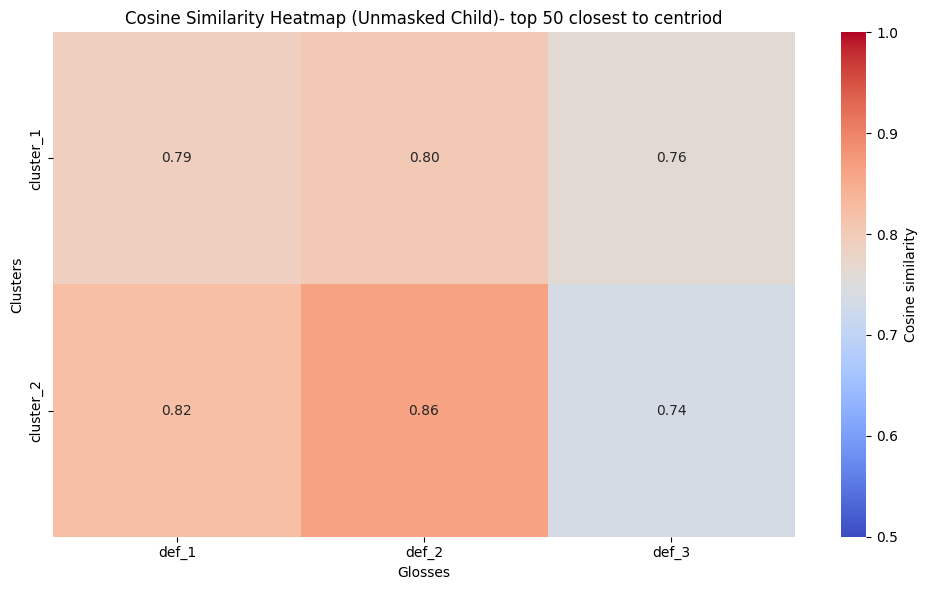

In [ ]:
# Heatmap for unmasked
plt.figure(figsize=(10,6))

sns.heatmap(
    cosine_unmasked,
    xticklabels=gloss_names,   # x = clusters
    yticklabels=cluster_names,     # y = glosses
    cmap="coolwarm",
    vmin=0.5, vmax=1,
    annot=True, fmt=".2f",
    cbar_kws={"label": "Cosine similarity"}
)

plt.xlabel("Glosses")
plt.ylabel("Clusters")
plt.title("Cosine Similarity Heatmap (Unmasked Child)- top 50 closest to centriod")
plt.tight_layout()
plt.show()